# An Empirical Comparison of Supervised and Self-Supervised Learning

In [1]:
import tqdm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from sklearn.svm import SVC
from sklearn.manifold import TSNE

from train import train_encoder, train_ConvNet, TrainArgs
from test import encode_data, plot_tsne, test_conv

from torch.utils.data import Subset

In [2]:
%load_ext autoreload
%autoreload 2

## Baseline: convolutional neural network

In [3]:
conv_args = TrainArgs(batchsize = 10)

In [4]:
ConvNet, conv_losses = train_ConvNet(conv_args)

100%|██████████| 170498071/170498071 [00:17<00:00, 9520768.70it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Started looping
[epoch: 0, i:   499] avg mini-batch loss: 2.301
[epoch: 0, i:   999] avg mini-batch loss: 2.290
[epoch: 0, i:  1499] avg mini-batch loss: 2.244
[epoch: 0, i:  1999] avg mini-batch loss: 2.131
[epoch: 0, i:  2499] avg mini-batch loss: 2.042
[epoch: 0, i:  2999] avg mini-batch loss: 1.958
[epoch: 0, i:  3499] avg mini-batch loss: 1.868
[epoch: 0, i:  3999] avg mini-batch loss: 1.800
[epoch: 0, i:  4499] avg mini-batch loss: 1.754
[epoch: 0, i:  4999] avg mini-batch loss: 1.696
[epoch: 1, i:   499] avg mini-batch loss: 1.649
[epoch: 1, i:   999] avg mini-batch loss: 1.641
[epoch: 1, i:  1499] avg mini-batch loss: 1.604
[epoch: 1, i:  1999] avg mini-batch loss: 1.588
[epoch: 1, i:  2499] avg mini-batch loss: 1.525
[epoch: 1, i:  2999] avg mini-batch loss: 1.522
[epoch: 1, i:  3499] avg mini-batch loss: 1.502
[epoch: 1, i:  3999] avg mini-batch loss: 1.487
[epoch: 1, i:  4499] avg mini-batch loss: 1.466
[epoch: 1, i:  4999] 

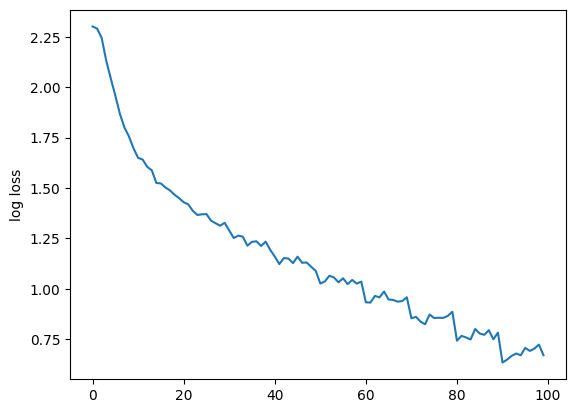

In [5]:
plt.plot(conv_losses);
plt.ylabel('log loss');

In [6]:
print(f'Baseline accuracy of the convolutional model is {test_conv(ConvNet)*100} %')

Files already downloaded and verified
Baseline accuracy of the convolutional model is 64.24 %


## Momentum Contrast

### Pre-Training the Encoder

In [7]:
encoder_args = TrainArgs(epochs = 40)

In [8]:
encoder, enc_losses = train_encoder(encoder_args)

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 	Loss: 0.031612
Train Epoch: 2 	Loss: 0.011258
Train Epoch: 3 	Loss: 0.006209
Train Epoch: 4 	Loss: 0.004487
Train Epoch: 5 	Loss: 0.003687
Train Epoch: 6 	Loss: 0.003264
Train Epoch: 7 	Loss: 0.002970
Train Epoch: 8 	Loss: 0.002737
Train Epoch: 9 	Loss: 0.002564
Train Epoch: 10 	Loss: 0.002387
Train Epoch: 11 	Loss: 0.002264
Train Epoch: 12 	Loss: 0.002183
Train Epoch: 13 	Loss: 0.002052
Train Epoch: 14 	Loss: 0.001953
Train Epoch: 15 	Loss: 0.001919
Train Epoch: 16 	Loss: 0.001813
Train Epoch: 17 	Loss: 0.001746
Train Epoch: 18 	Loss: 0.001717
Train Epoch: 19 	Loss: 0.001658
Train Epoch: 20 	Loss: 0.001597
Train Epoch: 21 	Loss: 0.001567
Train Epoch: 22 	Loss: 0.001503
Train Epoch: 23 	Loss: 0.001465
Train Epoch: 24 	Loss: 0.001462
Train Epoch: 25 	Loss: 0.001390
Train Epoch: 26 	Loss: 0.001378
Train Epoch: 27 	Loss: 0.001328
Train Epoch: 28 	Loss: 0.001320
Train Epoch: 29 	Loss: 0.001265
Train

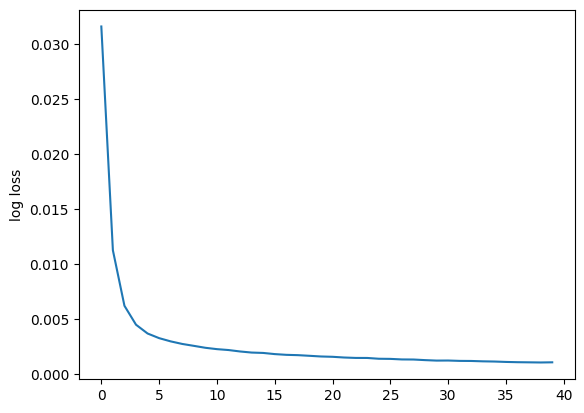

In [9]:
plt.plot(enc_losses);
plt.ylabel('log loss');

### Visualizing Embeddings

To do:
1. Implement multiple training ratios
2. Hyperparameter tuning?
3. Plot the loss functions

In [10]:
data, targets = encode_data()

Files already downloaded and verified


  2%|▏         | 189/10000 [00:02<01:53, 86.31it/s]

100%|██████████| 10000/10000 [01:58<00:00, 84.54it/s]


In [11]:
ret = TSNE(n_components=2, random_state=0, n_jobs=8).fit_transform(data)

Files already downloaded and verified


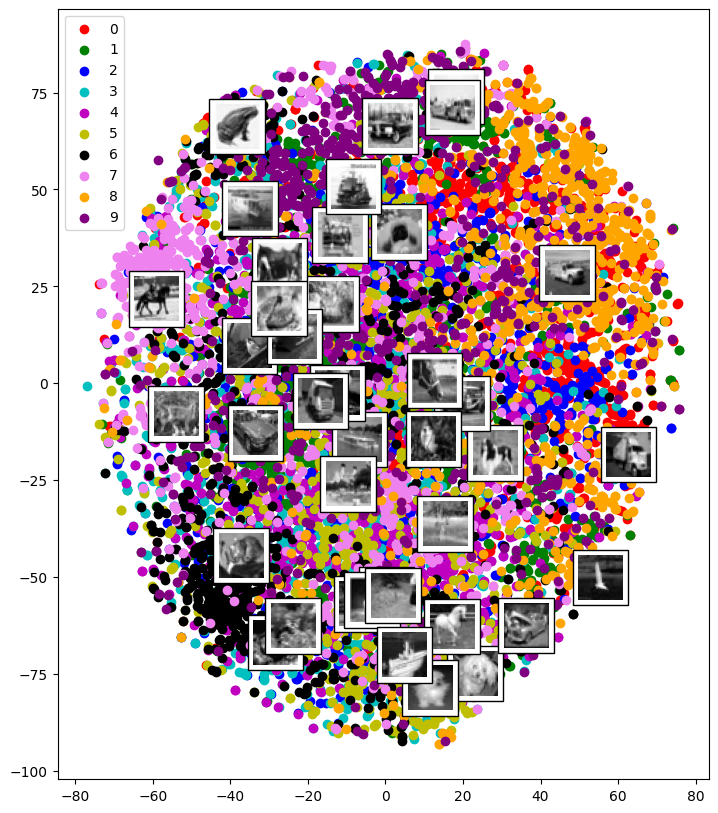

In [12]:
plot_tsne(targets, ret)

### Training SVM on freezed features

In [13]:
X_train, y_train = encode_data(train=True)
X_test, y_test = encode_data(train=False)

Files already downloaded and verified


  1%|          | 259/50000 [00:03<09:58, 83.05it/s]

100%|██████████| 50000/50000 [09:43<00:00, 85.70it/s]


Files already downloaded and verified


100%|██████████| 10000/10000 [01:56<00:00, 85.70it/s]


In [14]:
svm = SVC(C = 100,  gamma='scale')
svm.fit(X_train, y_train)

SVC(C=100)

In [15]:
svm.score(X_test, y_test)

0.6522

### Multiple Runs

In [16]:
# subsample so things run faster
X_train, y_train = encode_data(train=True, subsample = True)
X_test, y_test = encode_data(train=False, subsample = True)

Files already downloaded and verified


  5%|▌         | 261/5000 [00:02<00:53, 89.14it/s]

100%|██████████| 5000/5000 [00:58<00:00, 86.01it/s]


Files already downloaded and verified


100%|██████████| 1000/1000 [00:11<00:00, 85.31it/s]


In [17]:
conv_args = TrainArgs(batchsize = 10, epochs = 5)

In [18]:
n = 3
conv_errors = []
svm_errors = []
for i in range(n):
    ConvNet, conv_losses = train_ConvNet(conv_args, subsample=True)
    conv_errors.append(test_conv(ConvNet, subsample=True)*100)
    
    svm = SVC(C = 100,  gamma='scale')
    svm.fit(X_train, y_train)   
    svm_errors.append(svm.score(X_test, y_test))

Files already downloaded and verified
Started looping
[epoch: 0, i:   499] avg mini-batch loss: 2.302
[epoch: 1, i:   499] avg mini-batch loss: 2.298
[epoch: 2, i:   499] avg mini-batch loss: 2.291
[epoch: 3, i:   499] avg mini-batch loss: 2.275
[epoch: 4, i:   499] avg mini-batch loss: 2.240
Files already downloaded and verified


Files already downloaded and verified
Started looping
[epoch: 0, i:   499] avg mini-batch loss: 2.303
[epoch: 1, i:   499] avg mini-batch loss: 2.301
[epoch: 2, i:   499] avg mini-batch loss: 2.299
[epoch: 3, i:   499] avg mini-batch loss: 2.292
[epoch: 4, i:   499] avg mini-batch loss: 2.268
Files already downloaded and verified
Files already downloaded and verified
Started looping
[epoch: 0, i:   499] avg mini-batch loss: 2.302
[epoch: 1, i:   499] avg mini-batch loss: 2.298
[epoch: 2, i:   499] avg mini-batch loss: 2.289
[epoch: 3, i:   499] avg mini-batch loss: 2.271
[epoch: 4, i:   499] avg mini-batch loss: 2.245
Files already downloaded and verified


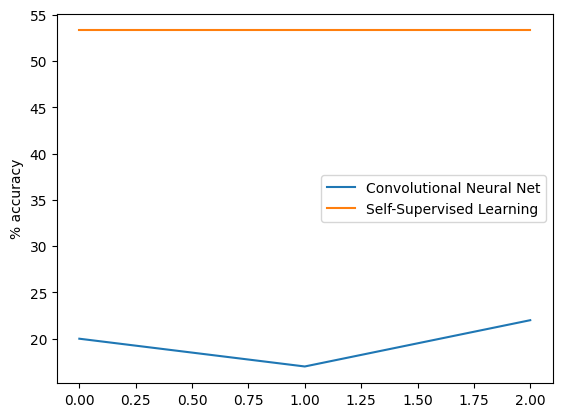

In [19]:
plt.plot(np.array(conv_errors), label="Convolutional Neural Net")
plt.plot(np.array(svm_errors)*100, label="Self-Supervised Learning")
plt.legend()
plt.ylabel('% accuracy')
plt.savefig('./results/comparison.png')

In [20]:
conv_errors

[20.0, 17.0, 22.0]

In [21]:
svm_errors

[0.533, 0.533, 0.533]

In [22]:
conv_errors

[20.0, 17.0, 22.0]